In [4]:
import pandas as pd
import wikipediaapi
import requests
from bs4 import BeautifulSoup
import time
import wikipedia

# Load your album file
df = pd.read_csv("albums_final.csv")  # <- Make sure this file is in the same directory

# Initialize Wikipedia API
wiki = wikipediaapi.Wikipedia(
    language="en",
    user_agent="album-genre-scraper/1.0 (contact: rr1303@georegetown.edu)"
)


def get_first_genre(album_title):
    try:
        search_results = wikipedia.search(album_title)
        if not search_results:
            print(f"❌ No Wikipedia results for: {album_title}")
            return None

        top_title = search_results[0]
        page = wiki.page(top_title)

        if not page.exists():
            print(f"❌ Wikipedia page does not exist for: {top_title}")
            return None

        print(f"🌐 Found page: {top_title} ({page.fullurl})")

        # Scrape the infobox
        url = page.fullurl
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "lxml")
        infobox = soup.find("table", class_="infobox")

        if infobox:
            for row in infobox.find_all("tr"):
                header = row.find("th")
                if header and "genre" in header.text.lower():
                    genre_cell = row.find("td")
                    if genre_cell:
                        genre_items = genre_cell.find_all(["a", "li"])
                        if genre_items:
                            genres = [item.get_text(strip=True) for item in genre_items]
                            if genres:
                                return genres[0]  # First genre
                        else:
                            genre_text = genre_cell.get_text(separator=",").strip()
                            if genre_text:
                                return genre_text.split(",")[0].strip()
        return None  # ✅ <- Move this outside the for loop
    except Exception as e:
        print(f"⚠️ Error processing {album_title}: {e}")
        return None


# Apply genre extraction (with delay to respect Wikipedia)
genre_list = []

for i, album in enumerate(df["album_name"]):
    if pd.notnull(album):
        genre = get_first_genre(album)
        print(f"[{i+1}/{len(df)}] Album: {album} → Genre: {genre}")
        genre_list.append(genre)
    else:
        print(f"[{i+1}/{len(df)}] Album: {album} → Skipped (null)")
        genre_list.append(None)

    # Optional delay to be polite
    time.sleep(1)

    # Optional: save every 100 albums
    if i % 100 == 0 and i > 0:
        df_partial = df.iloc[:i+1].copy()
        df_partial["first_genre"] = genre_list
        df_partial.to_csv("albums_with_genres_partial.csv", index=False)
        print(f"💾 Progress saved at row {i+1}")

# Final save
df["first_genre"] = genre_list
df.to_csv("albums_with_genres.csv", index=False)
print("✅ Done! Final genres saved.")



🌐 Found page: The Tortured Poets Department (https://en.wikipedia.org/wiki/The_Tortured_Poets_Department)
[1/3289] Album: THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY → Genre: Chamber pop
🌐 Found page: The Tortured Poets Department (https://en.wikipedia.org/wiki/The_Tortured_Poets_Department)
[2/3289] Album: THE TORTURED POETS DEPARTMENT → Genre: Chamber pop
🌐 Found page: 1989 (Taylor's Version) (https://en.wikipedia.org/wiki/1989_(Taylor%27s_Version))
[3/3289] Album: 1989 (Taylor's Version) [Deluxe] → Genre: Synth-pop
🌐 Found page: 1989 (Taylor's Version) (https://en.wikipedia.org/wiki/1989_(Taylor%27s_Version))
[4/3289] Album: 1989 (Taylor's Version) → Genre: Synth-pop
🌐 Found page: Speak Now (Taylor's Version) (https://en.wikipedia.org/wiki/Speak_Now_(Taylor%27s_Version))
[5/3289] Album: Speak Now (Taylor's Version) → Genre: Country pop
🌐 Found page: Higher (https://en.wikipedia.org/wiki/Higher)
[6/3289] Album: Higher → Genre: None
🌐 Found page: Starting Over (https://en.wikipedia.o

In [3]:
import pandas as pd
# Count how many rows have missing genres
df = pd.read_csv("albums_with_genres.csv")
num_none = df["first_genre"].isna().sum()
print(f"🎯 Albums with no genre found: {num_none} out of {len(df)}")


🎯 Albums with no genre found: 1465 out of 3289


In [4]:
import pandas as pd
import requests
import time
import re
import random

# === CONFIG ===
API_KEY = '167449f0e33d663e89e0bf8193762bec'  # 👈 Replace this with your Last.fm API key
API_URL = 'http://ws.audioscrobbler.com/2.0/'
INPUT_FILE = 'albums_with_genres.csv'
OUTPUT_FILE = 'albums_genres_filled.csv'

# === Load dataset ===
df = pd.read_csv(INPUT_FILE)

# === Function to get genre from artist only ===
def get_artist_genre(artist, retries=3):
    params = {
        'method': 'artist.getTopTags',
        'artist': artist,
        'api_key': API_KEY,
        'format': 'json'
    }

    for attempt in range(retries):
        try:
            time.sleep(random.uniform(0.45, 0.65))  # be polite to Last.fm
            response = requests.get(API_URL, params=params)
            if response.status_code != 200:
                continue
            data = response.json()

            tags = data.get('toptags', {}).get('tag', [])
            if tags:
                for tag in tags:
                    name = tag.get('name', '').strip().lower()
                    if not re.fullmatch(r'\d{4}', name):  # avoid year-like tags
                        return name
            return 'Unknown'
        except Exception as e:
            print(f"Error for artist '{artist}' on attempt {attempt + 1}: {e}")
            time.sleep(1 + attempt)
    return 'Error'

# === Filter albums with missing genre ===
missing_genre = df[df["first_genre"].isna()].copy()
print(f"🔍 Found {len(missing_genre)} albums with missing genre")

# === Get genres using artist fallback ===
fallback_genres = []
for index, row in missing_genre.iterrows():
    artist = row['artist_name']
    genre = get_artist_genre(artist)
    print(f"🎵 {row['album_name']} by {artist} → {genre}")
    fallback_genres.append(genre)

# Add these genres to the missing rows
missing_genre["first_genre"] = fallback_genres

# === Merge updated rows back ===
df_updated = df.copy()
df_updated.update(missing_genre)

# === Save updated file ===
df_updated.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Final dataset saved as '{OUTPUT_FILE}'")


🔍 Found 1465 albums with missing genre
🎵 Higher by Chris Stapleton → country
🎵 Starting Over by Chris Stapleton → country
🎵 Traveller by Chris Stapleton → country
🎵 The Party Never Ends 2.0 by Juice WRLD → hip-hop
🎵 Legends Never Die by Juice WRLD → hip-hop
🎵 MUSIC by Playboi Carti → trap
🎵 Live At SoFi Stadium by The Weeknd → rnb
🎵 Bright Future by Adrianne Lenker → singer-songwriter
🎵 songs by Adrianne Lenker → singer-songwriter
🎵 instrumentals by Adrianne Lenker → singer-songwriter
🎵 b-sides by Adrianne Lenker → singer-songwriter
🎵 american dream by 21 Savage → trap
🎵 american dream (sped up) by 21 Savage → trap
🎵 american dream (slowed down) by 21 Savage → trap
🎵 Grandson by King Von → drill
🎵 HOOD POET by Polo G → rap
🎵 Hall of Fame 2.0 by Polo G → rap
🎵 Hall of Fame by Polo G → rap
🎵 THE GOAT by Polo G → rap
🎵 THE GOAT by Polo G → rap
🎵 LARGER THAN LIFE (CHOPPED NOT SLOPPED) by Brent Faiyaz → rnb
🎵 WASTELAND by Brent Faiyaz → rnb
🎵 Fuck The World by Brent Faiyaz → rnb
🎵 Currents 

In [6]:
df = pd.read_csv("albums_genres_filled.csv")
# Drop missing values just in case
genre_counts = df["first_genre"].dropna().value_counts()

# Display top genres
print(genre_counts.head(20))

first_genre
Hip hop             187
pop                 138
rap                 136
Pop                 125
Country             115
country             112
rnb                  88
R&B                  86
hip-hop              68
Hip-hop              58
female vocalists     53
seen live            51
electronic           50
soul                 49
Indie rock           43
folk                 41
Alternative rock     38
indie                36
Regional Mexican     34
Rock                 32
Name: count, dtype: int64


In [4]:
import pandas as pd
import re 
df = pd.read_csv('albums_genres_filled.csv')

In [18]:
GENRE_KEYWORDS = [
    "pop", "rock", "rap", "hip hop", "trap", "country", "metal", "r&b", 
    "jazz", "indie", "electronic", "house", "techno", "reggae", "folk", 
    "funk", "soul", "punk", "blues", "alternative", "classical", "ambient", 
    "k-pop", "kids", "afrobeats","relaxed","latin"
]

# Mapping of leftover genre tags to canonical genres
MANUAL_GENRE_MAP = {
    # rock
    "psychedelic": "rock", "post-rock": "rock", "post grunge": "rock", "grunge": "rock",
    "shoegaze": "rock", "canadian": "rock", "deathcore":"rock", 

    # pop
    "female vocalist": "pop", "female vocalists": "pop", "5 seconds of summer": "pop",
    "synthpop": "pop", "tatemcrae": "pop", "my top songs": "pop", "sexy": "pop",
    "bee gees": "pop", "hyperpop": "pop", "digital tendencies": "pop", "2-step": "pop",
    "acoustic": "pop", "comedy": "pop", "singer-songwriter": "pop", "3": "pop",
    "disco": "pop", "wedding": "pop", "30": "pop", "peter": "pop", "midnights": "pop",
    "poptron": "pop", "doo-wop": "pop", "male vocals": "pop", "new wave": "pop",
    "later": "pop", "joaoaksnes": "pop", "madonna": "pop", "portals": "pop",
    "aoty": "pop", "mayhem": "pop", "guts": "pop", "short n' sweet": "pop",
    "soty": "pop", "cypriot": "pop", "breakbeat": "pop", "chinese": "pop",
    "german": "pop", "absolute bangers": "pop", "danish": "pop", "azerbaijan": "pop",
    "hardstyle": "pop", "japanese": "pop", "argentina": "pop", "indian": "pop",
    "india": "pop", "bhangra": "pop", "nigeria": "pop", "bollywood": "pop",
    "italian": "pop", "morocco": "pop", "traditional": "pop","ukrainian":"pop",
    "fairy tale": "pop", "romantic comedy": "pop", "memoir": "pop", "romantic": "pop", "80s": "pop", 
    "k ballad": "pop", "show tune": "pop", "hamilton": "pop","comedy drama": "pop", "modernist novel": "pop", 
    "drama": "pop", "sitcom": "pop", "teen sitcom": "pop", "eurodisco": "pop",
    "romantic comedy": "pop","black comedy": "pop","chanson": "pop","filmi": "pop", "better than selena gomez": "pop",
    "historical drama" : "pop", "action adventure": "pop", "action" : "pop", "historical drama":"pop",
    "crime thriller":"pop","malaysian":"pop",
    # latin
    "puerto rico": "latin", "mexico": "latin", "sad sierreno": "latin",
    "lada del 602": "latin", "corridos tumbados": "latin", "seen live": "latin",
    "ramito de violeta": "latin", "chickencore": "latin", "corona": "latin",
    "cuck": "latin", "luar la l": "latin", "peso pluma": "latin", "spanish": "latin",
    "bachata": "latin", "salsa": "latin", "mierda": "latin", "banda": "latin",
    "duranguense": "latin", "romantico grupero": "latin", "colombia": "latin",
    "drum and bass": "latin", "sertanejo": "latin", "pagode": "latin", "samba": "latin","corrido tumbado":"latin","mexican":"latin","spain":"latin",
    "plena" : "latin", "regional mexican": "latin", "corridos": "latin", "grupero": "latin", "urbano": "latin",
    "cuban": "latin", "cuban son": "latin", "dominican dembow": "latin", "bolero": "latin",
    "tex mex": "latin", "merengue": "latin", "mpb": "latin", "tropicália": "latin", "zouk": "latin",
    "mariachi": "latin", "norteñocumbia": "latin", "norteño sax": "latin","argentine music": "latin", "zouk": "latin",
    "telenovela": "latin", "argentine music" : "latin",
    # relaxed
    "ambient": "relaxed", "sleep": "relaxed", "reiki": "relaxed", "instrumental": "relaxed",
    "lo-fi": "relaxed", "rain": "relaxed", "nature sounds": "relaxed", "chill": "relaxed",
    "nature": "relaxed", "noise": "relaxed", "eargasm": "relaxed", "chillout": "relaxed",
    "white noise": "relaxed", "piano": "relaxed", "hindi": "relaxed","ambient":"relaxed",
    "lo fi": "relaxed", "ambient" : "relaxed", "orchestral":"relaxed","action role playing":"relaxed","classical":"relaxed",

    # rap
    "harder than diamonds": "rap", "peak": "rap", "drill": "rap", "heavy": "rap",
    "my scribbled": "rap", "drake": "rap", "baby keem": "rap", "g59": "rap", "j cole": "rap",
    "tag lil tecca-lot of me": "rap", "kanye wes": "rap", "bronx drill": "rap",
    "transitions": "rap", "auto-tagged": "rap", "gunna": "rap", "mumble crap": "rap",
    "boom bap": "rap", "quirky": "rap", "underrated": "rap", "phonk": "rap",
    "chipmunk soul": "rap", "diss": "rap", "worst album ever": "rap", "nitrous": "rap",
    "juggin": "rap", "4 out of 5": "rap", "czech": "rap",
    "sematary grave man from the haunted mound real nazgul skincarver keeper of da trees haunted mound lord": "rap",
    "grime": "rap","juice wrld":"rap","polo g":"rap","lil uzi vert":"rap","kanye west":"rap", "opium":"rap", "sports":"rap",
    "historical":"rap", "horrorcore":"rap",

    # reggae
    "reggaeton": "reggae", "party": "reggae", "dancehall": "reggae", "love": "reggae",

    # hip hop
    "linedance": "hip hop", "nice": "hip hop", "florida": "hip hop", "don toliver": "hip hop",
    "southern hip-hop": "hip hop", "dr congo": "hip hop", "mother": "hip hop",
    "sampling": "hip hop", "plugg": "hip hop", "ebm": "hip hop", "egyptian": "hip hop",
    "a cappella": "hip hop", "ghana": "hip hop", "cumbia 420": "hip hop", "hip-hop": "hip hop","melodic hip-hop":"hip hop",
    "drill": "hip hop", "rhythm" : "hip hop", "racing" : "hip hop", "kart racing" : "hip hop", "gothic":"hip hop",

    # metal
    "metalcore": "metal", "progressive metalcore": "metal", "rage": "metal",
    "post hardcore": "metal", "demonic": "metal", "role playing video game": "metal", "post apocalyptic":"metal",

    # r&b
    "rnb": "r&b", "aggressive": "r&b", "king billionheir": "r&b", "love at first listen": "r&b",
    "personal favourites": "r&b", "sza": "r&b", "british": "r&b", "3 out of 5": "r&b","steve lacy":"r&b",
    "non fiction": "r&b", "highlife":"r&b",

    # k-pop
    "bts": "k-pop", "kpop": "k-pop", "korean": "k-pop", "jersey club": "k-pop", "it boy global": "k-pop", "fast food":"k-pop",

    # religious
    "christian": "religious", "ccm": "religious", "worship": "religious", "gospel": "religious",
    "musiclist": "religious", "experimental": "religious", "hariharan": "religious", "thai": "religious",
    "contemporary christian music": "religious", "contemporary gospel": "religious", "worship": "religious",
    "gospel": "religious", "ccm": "religious", "christian": "religious", "religious": "religious",
    "christian contemporary": "religious", "christian novels": "religious", "contemporary worship music": "religious", 
    "contemporary worship": "religious",

    # electronic
    "depressive": "electronic", "indietronica": "electronic", "synthwave": "electronic",
    "childish gamblingo": "electronic", "featuring": "electronic", "trance": "electronic",
    "ass": "electronic", "downtempo": "electronic", "dance": "electronic", "60s": "electronic",
    "polish": "electronic", "russian": "electronic", "norway": "electronic", "eurodance": "electronic",
    "remix": "electronic", "frenchcore": "electronic", "uk garage": "electronic",
    "film score": "electronic", "electro": "electronic", "drone": "electronic", "trip hop": "electronic",
    "future bass": "electronic", "edm": "electronic", "anison": "electronic", "industrial": "electronic", "techno": "electronic",
    "amapiano": "electronic", "cinema playback singing": "electronic", "uk drill": "electronic", "first person shooter": "electronic",
    "fixed shooter": "electronic", "first person shooter(primary)": "electronic","belgium": "latin","role playing" : "electronic", 
    "chopped and screwed":"electronic", "literary fiction": "electronic", "science fiction role playing game":"electronic",

    # indie
    "songs i crank my hog to": "indie", "bossa nova": "indie", "wsum 91.7 fm madison": "indie",
    "songs i like to play whilst walking down the street at night music": "indie",
    "gambling addiction": "indie", "emo": "indie", "darkwave": "indie", "slowcore": "indie",
    "stolen": "indie", "life changing": "indie", "vinyl": "indie", "gothangelz": "indie",
    "ai": "indie", "ukranian": "indie", "opm": "indie", "singer songwriter" : "indie",

    # afrobeats
    "afrobeats": "afrobeats", "kenyan": "afrobeats","afrobeat": "afrobeats", "afro fusion": "afrobeats","beat": "afrobeats",

    # country
    "usa": "country", "fearless": "country", "linedance 2021": "country", "texas": "country",
    "feel good": "country", "furry": "country", "linedance catalan": "country", "american": "country", "haunted": "country","linedance 2022":"country",
    "americana": "country", "red dirt": "country", "bluegrass": "country", "western": "country","serial drama": "country",
    "patriotic song": "country", "horror": "country", "romance":"country", "post hardcore":"country",

    # kids
    "soundtrack": "kids", "video game music": "kids", "australian": "kids", "disney": "kids",
    "musical": "kids", "infantil": "kids",
    "film soundtrack": "kids", "soundtrack": "kids", "musical": "kids", "doo wop": "kids", "christmas": "kids",
    "children's literature": "kids", "christmas special": "kids", "christmas carol": "kids", "christmas music": "kids",
    "game show": "kids", "soundtrack": "kids", "video game music": "kids", "australian": "kids", "disney": "kids",
    "musical": "kids", "infantil": "kids", "film soundtrack": "kids", "doo wop": "kids", "christmas": "kids","children's literature": "kids", 
    "christmas special": "kids", "christmas carol": "kids", "christmas music": "kids","game show": "kids","fantasy": "kids", 
    "adventure": "kids", "mystery": "kids","narrative poem": "kids", "portal fantasy": "kids", "situation comedy": "kids", 
    "late night talk show": "kids", "8 bit": "kids", "board game": "kids", "feature film soundtrack": "kids", "chant": "kids",

    # trap
    "detroit trap": "trap", "rage" : "trap",

    # funk
    "brazil": "funk",

    # folk
    "arabic": "folk"
}

def map_to_final_genre(genre_str):
    genre_str_lower = str(genre_str).strip().lower()
    genre_str_lower = re.sub(r"\[\d+\]", "", genre_str_lower)
    genre_str_lower = genre_str_lower.replace("-", " ")

    # 🔁 Check exact match in manual mapping FIRST
    if genre_str_lower in MANUAL_GENRE_MAP:
        return MANUAL_GENRE_MAP[genre_str_lower]

    # ✅ THEN check if part of GENRE_KEYWORDS
    for genre in GENRE_KEYWORDS:
        if genre in genre_str_lower:
            return genre

    return genre_str_lower

# def map_to_final_genre(genre_str):
#     genre_str_lower = str(genre_str).strip().lower()
#     # Clean bracketed footnotes like [1], [2]
#     genre_str_lower = re.sub(r"\[\d+\]", "", genre_str_lower)
#     genre_str_lower = genre_str_lower.replace("-", " ")
#     # Check canonical match
#     for genre in GENRE_KEYWORDS:
#         if genre in genre_str_lower:
#             return genre

#     # Check exact match in manual mapping
#     if genre_str_lower in MANUAL_GENRE_MAP:
#         return MANUAL_GENRE_MAP[genre_str_lower]

#     # Return as-is if not matched
#     return genre_str_lower

# Apply to your DataFrame
df['genre_cleaned'] = df['first_genre'].apply(map_to_final_genre)
df.to_csv("albums_with_final_genres.csv", index=False)

In [17]:
df["genre_cleaned"].unique()

array(['pop', 'country', 'hip hop', 'rap', 'r&b', 'indie', 'folk', 'trap',
       'latin', 'reggae', 'electronic', 'rock', 'soul', 'house',
       'relaxed', 'unknown', 'kids', 'religious', 'metal', 'punk', 'jazz',
       'funk', 'afrobeats', 'blues', 'k-pop', 'alternative'], dtype=object)

In [19]:
df = pd.read_csv("albums_with_final_genres.csv")
genre_map = {
    # Hip hop & Rap
    'hip hop': 'rap/hip hop',
    'rap': 'rap/hip hop',
    'trap': 'rap/hip hop',
    # Rock & Alt
    'rock': 'rock/alt',
    'punk': 'rock/alt',
    'alternative': 'rock/alt',
    'metal': 'rock/alt',  
    # Soul/Jazz/Funk
    'soul': 'soul/jazz',
    'jazz': 'soul/jazz',
    'funk': 'soul/jazz',
    # Country & Folk
    'country': 'country/folk',
    'folk': 'country/folk',
    # Electronic
    'electronic': 'electronic',
    'house': 'electronic',
}

# Apply the mapping
df['genre_condensed'] = df['genre_cleaned'].replace(genre_map)
df.to_csv('albums_with_final_genres.csv', index=False)

In [6]:
import pandas as pd
# Read the data from the CSV file
# Load the dataset, ensuring the correct row is used for headers
df = pd.read_csv("albums_with_final_genres.csv", header=1)

# Check the column names after loading the CSV
print(df.columns)

Index(['artist_name', 'artist_id', 'genre', 'album_id', 'album_name',
       'release_date', 'total_tracks', 'popularity', 'image_url',
       'genre_condensed'],
      dtype='object')


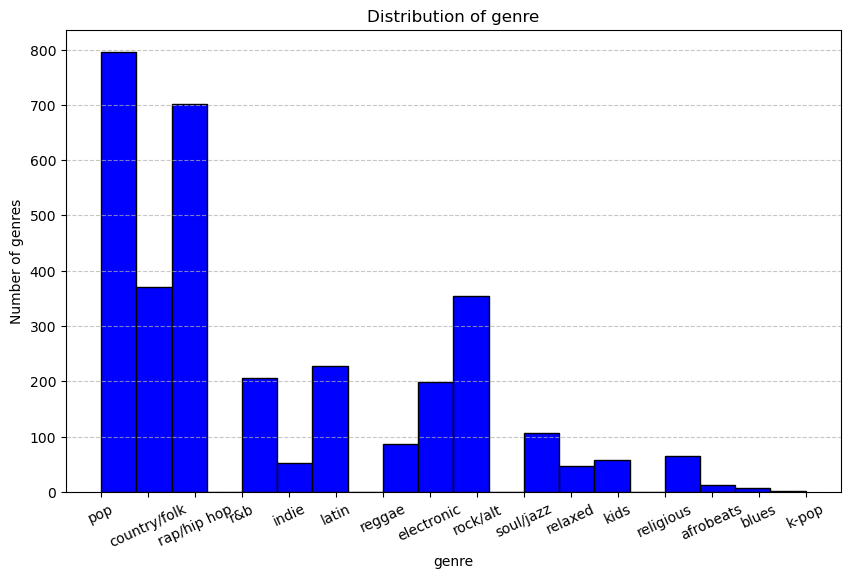

In [7]:
import matplotlib.pyplot as plt
# Plot distribution of album popularity
plt.figure(figsize=(10, 6))
plt.hist(df['genre_condensed'], bins=20, edgecolor='black', color='blue')
plt.title('Distribution of genre')
plt.xlabel('genre')
plt.ylabel('Number of genres')
plt.xticks(rotation=25)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/rachnarawalpally/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:06<00:00, 27.8MB/s] 


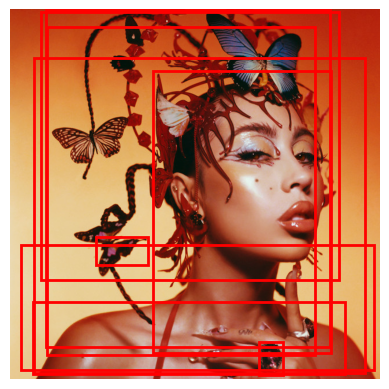

: 

In [8]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms

# Load Faster R-CNN model (pretrained)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Load and prepare the image
image_path = "testimage.jpeg"  # Replace with your image path
image = Image.open(image_path)
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

# Run inference
with torch.no_grad():
    prediction = model(image_tensor)

# Draw bounding boxes on the image
plt.imshow(image)
ax = plt.gca()
for element in range(len(prediction[0]['boxes'])):
    box = prediction[0]['boxes'][element].numpy()
    ax.add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                               linewidth=2, edgecolor='r', facecolor='none'))

plt.axis('off')
plt.show()


In [2]:
import pandas as pd
# Read the data from the CSV file
# Load the dataset, ensuring the correct row is used for headers
df = pd.read_csv("final_eda_df.csv")

# Check the column names after loading the CSV
print(df.columns)

Index(['Unnamed: 0', 'artist_name', 'artist_id', 'genre', 'album_id',
       'album_name', 'release_date', 'total_tracks', 'popularity', 'image_url',
       ...
       'color_3_R', 'color_3_G', 'color_3_B', 'color_4_R', 'color_4_G',
       'color_4_B', 'color_5_R', 'color_5_G', 'color_5_B', 'gender_grouped'],
      dtype='object', length=102)


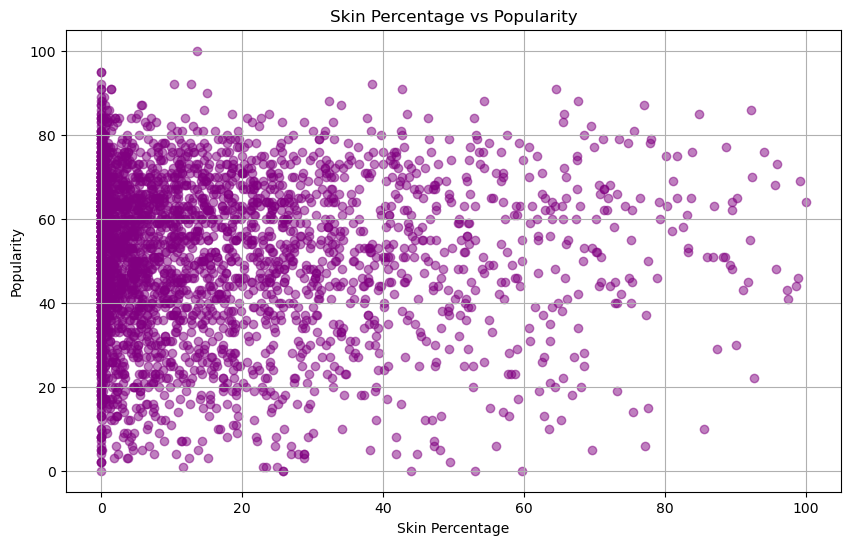

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['skin_percentage'], df['popularity'], alpha=0.5, color='purple')
plt.title('Skin Percentage vs Popularity')
plt.xlabel('Skin Percentage')
plt.ylabel('Popularity')
plt.grid(True)
plt.show()


/var/folders/7t/dpwxgyj14sn5gpv6rfjdybcw0000gn/T/ipykernel_90497/2269898700.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender_grouped', y='skin_percentage', data=df, palette='Set2')


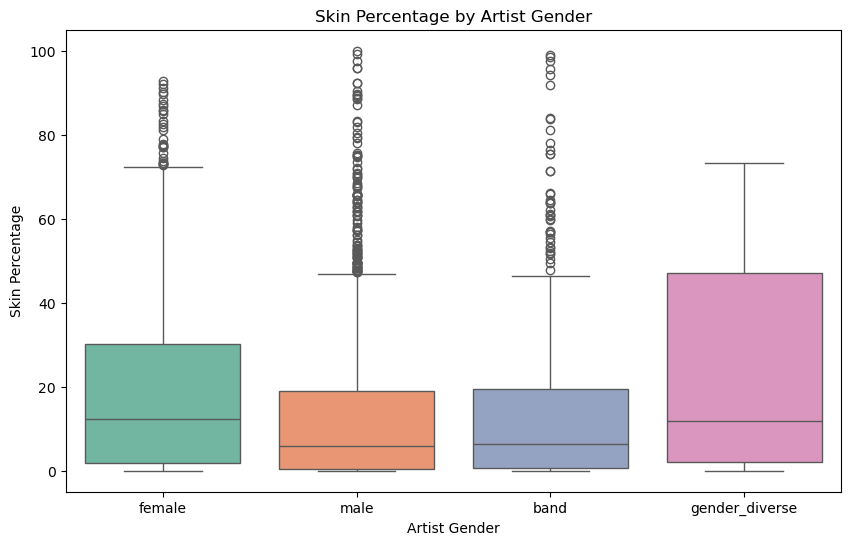

In [5]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender_grouped', y='skin_percentage', data=df, palette='Set2')
plt.title('Skin Percentage by Artist Gender')
plt.xlabel('Artist Gender')
plt.ylabel('Skin Percentage')
plt.show()

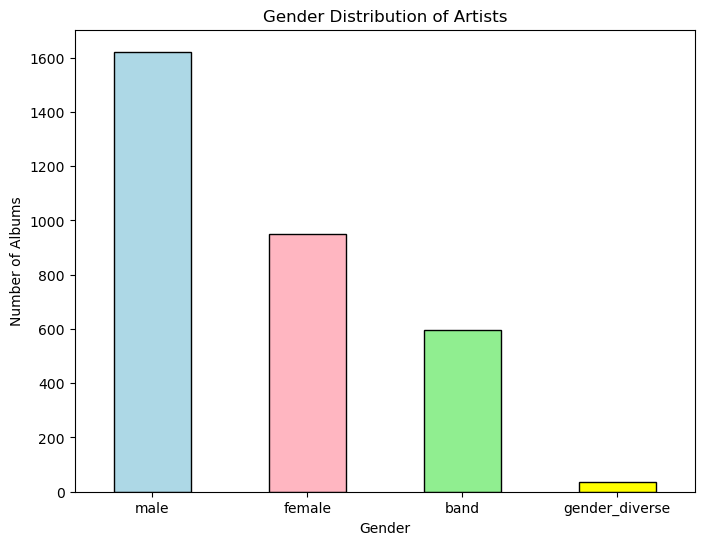

In [11]:
# Count the number of albums by gender
gender_counts = df['gender_grouped'].value_counts()

plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar', color=['lightblue', 'lightpink', 'lightgreen', 'yellow'], edgecolor='black')
plt.title('Gender Distribution of Artists')
plt.xlabel('Gender')
plt.ylabel('Number of Albums')
plt.xticks(rotation=0)  
plt.show()


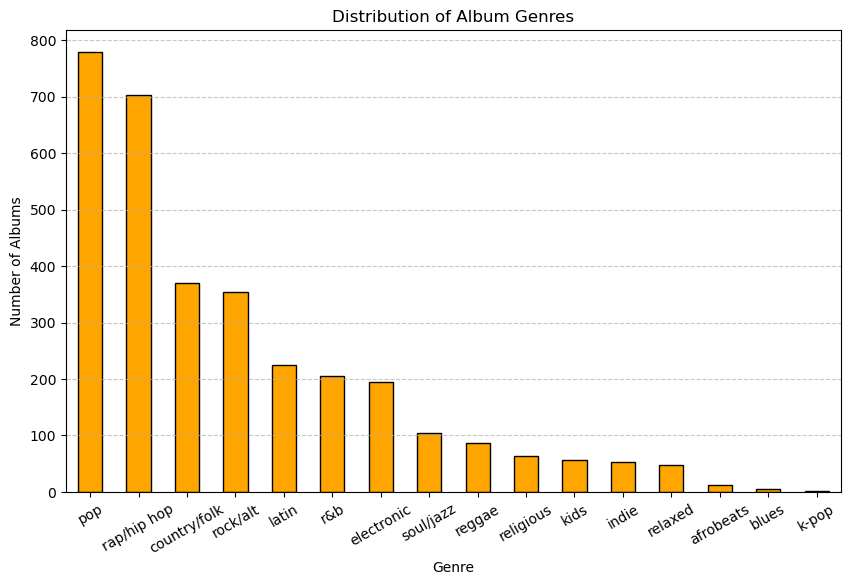

In [10]:
genre_counts = df['genre_condensed'].value_counts()
genre_counts.plot(kind='bar', figsize=(10, 6), color='orange', edgecolor='black')
plt.title('Distribution of Album Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Albums')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

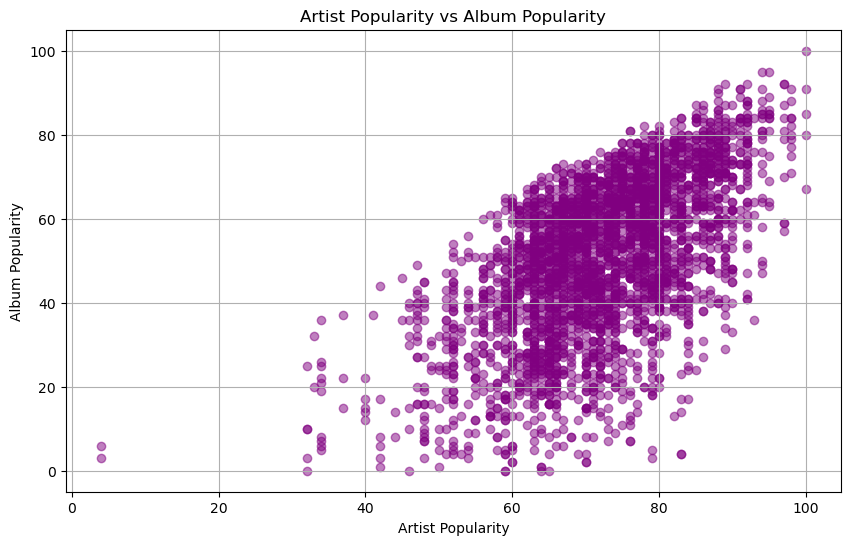

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(df['artist_popularity'], df['popularity'], alpha=0.5, color='purple')
plt.title('Artist Popularity vs Album Popularity')
plt.xlabel('Artist Popularity')
plt.ylabel('Album Popularity')
plt.grid(True)
plt.show()

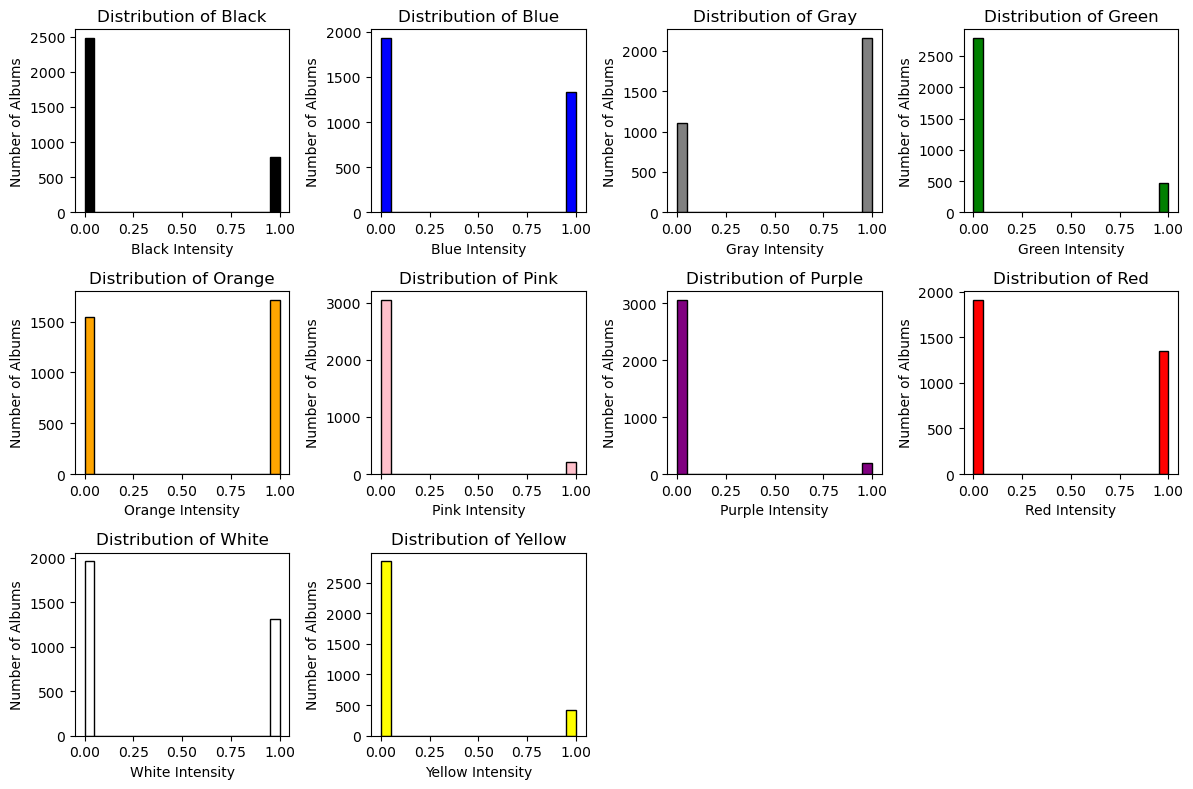

In [19]:
color_columns = ['black', 'blue', 'gray', 'green', 'orange', 'pink', 'purple', 'red', 'white', 'yellow']

plt.figure(figsize=(12, 8))
for i, color in enumerate(color_columns, 1):
    plt.subplot(3, 4, i)  # 3 rows and 4 columns of subplots
    plt.hist(df[color], bins=20, edgecolor='black', color=color)
    plt.title(f'Distribution of {color.capitalize()}')
    plt.xlabel(f'{color.capitalize()} Intensity')
    plt.ylabel('Number of Albums')

plt.tight_layout()
plt.show()


/var/folders/7t/dpwxgyj14sn5gpv6rfjdybcw0000gn/T/ipykernel_90497/3539771152.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Color', y='Intensity', data=melted_df, palette=color_palette)


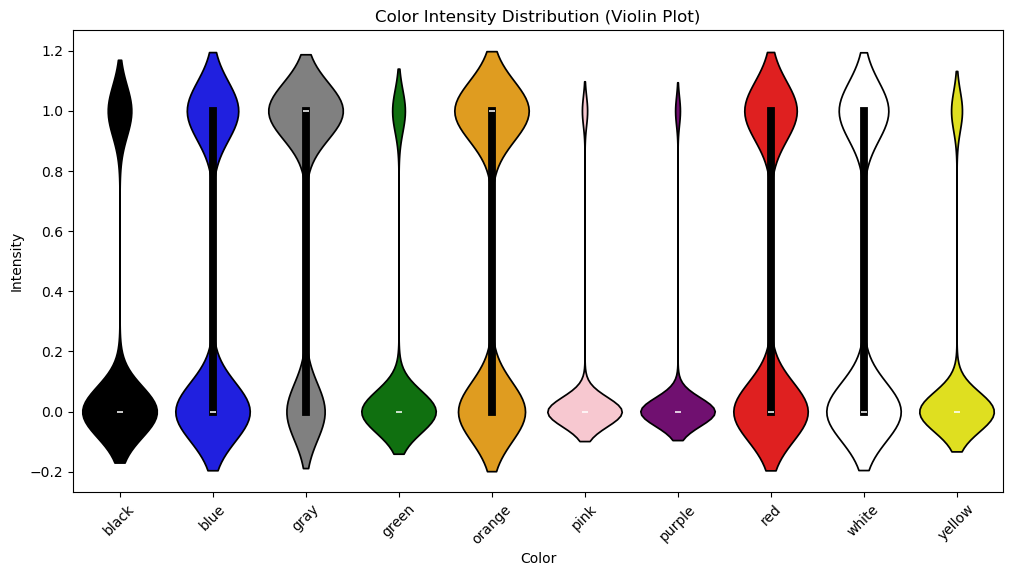

In [22]:
# Color palette matching 
color_palette = ['black', 'blue', 'gray', 'green', 'orange', 'pink', 'purple', 'red', 'white', 'yellow']

color_columns = ['black', 'blue', 'gray', 'green', 'orange', 'pink', 'purple', 'red', 'white', 'yellow']
melted_df = df[color_columns].melt(var_name='Color', value_name='Intensity')
plt.figure(figsize=(12, 6))
sns.violinplot(x='Color', y='Intensity', data=melted_df, palette=color_palette)
plt.title('Color Intensity Distribution (Violin Plot)')
plt.xlabel('Color')
plt.ylabel('Intensity')
plt.xticks(rotation=45)  
plt.show()

/var/folders/7t/dpwxgyj14sn5gpv6rfjdybcw0000gn/T/ipykernel_90497/3467319153.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genre_condensed', y='skin_percentage', data=df, palette="Set3")


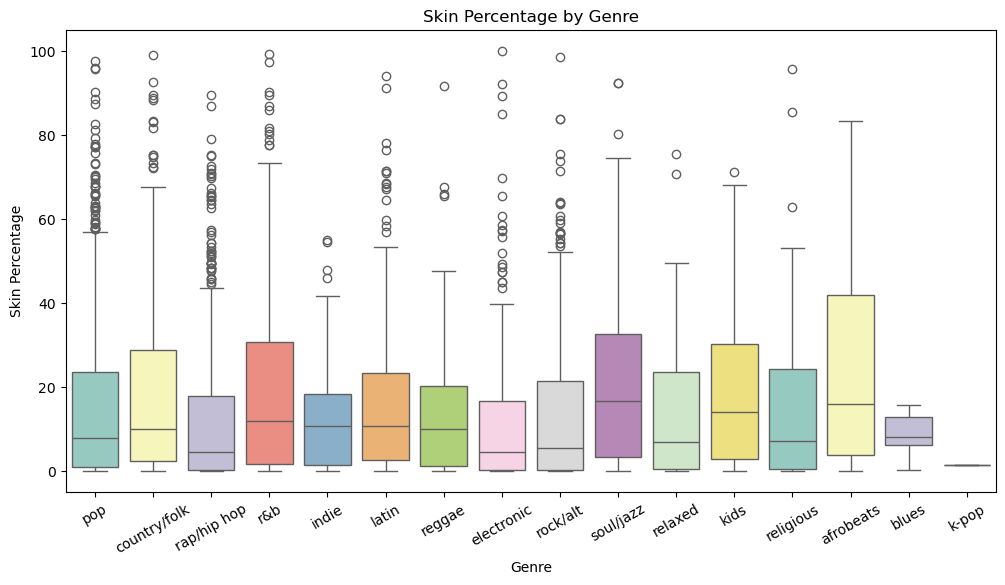

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot of skin percentage by genre
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre_condensed', y='skin_percentage', data=df, palette="Set3")
plt.title('Skin Percentage by Genre')
plt.xlabel('Genre')
plt.ylabel('Skin Percentage')
plt.xticks(rotation=30)  
plt.show()


In [38]:
# Sort the dataset by album popularity to find the top 10 albums
top_10_albums = df.nlargest(10, 'popularity')
# Create a new column to label top 10 and non-top 10 albums
df['is_top_10'] = df['album_id'].isin(top_10_albums['album_id'])

/var/folders/7t/dpwxgyj14sn5gpv6rfjdybcw0000gn/T/ipykernel_90497/1108543965.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_top_10', y='skin_percentage', data=df, palette='Set2')


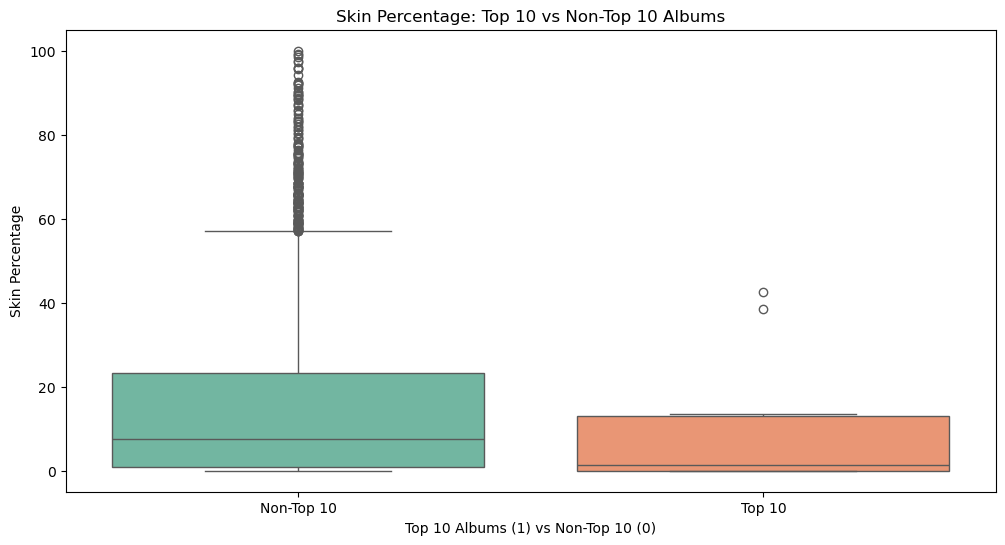

In [41]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_top_10', y='skin_percentage', data=df, palette='Set2')
plt.title('Skin Percentage: Top 10 vs Non-Top 10 Albums')
plt.xlabel('Top 10 Albums (1) vs Non-Top 10 (0)')
plt.ylabel('Skin Percentage')
plt.xticks([0, 1], ['Non-Top 10', 'Top 10'])
plt.show()


/var/folders/7t/dpwxgyj14sn5gpv6rfjdybcw0000gn/T/ipykernel_90497/3817749804.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genre_condensed', y='color_1_R', data=df, palette='Set3')


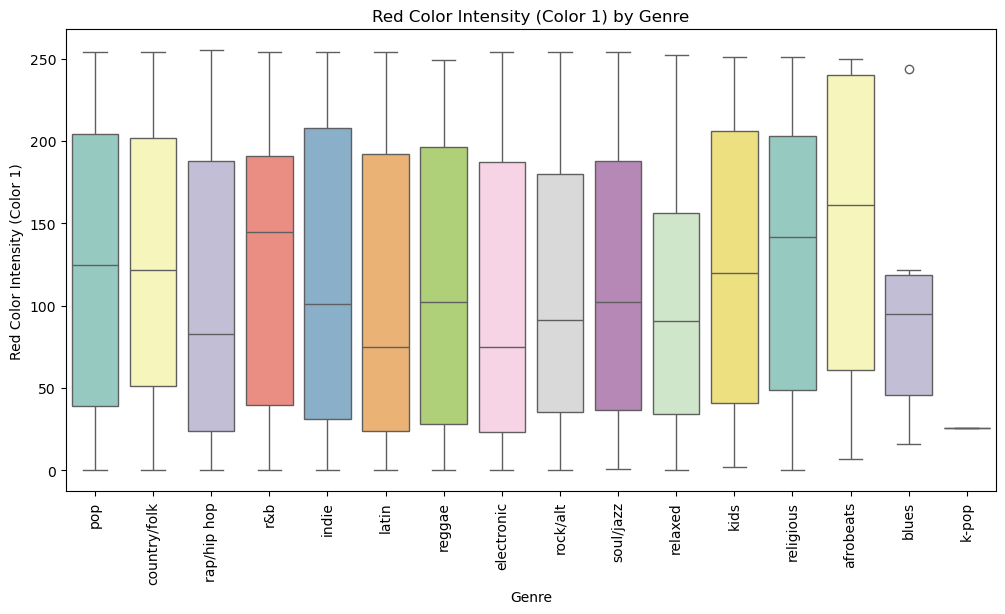

In [45]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre_condensed', y='color_1_R', data=df, palette='Set3')
plt.title('Red Color Intensity (Color 1) by Genre')
plt.xlabel('Genre')
plt.ylabel('Red Color Intensity (Color 1)')
plt.xticks(rotation=90)
plt.show()


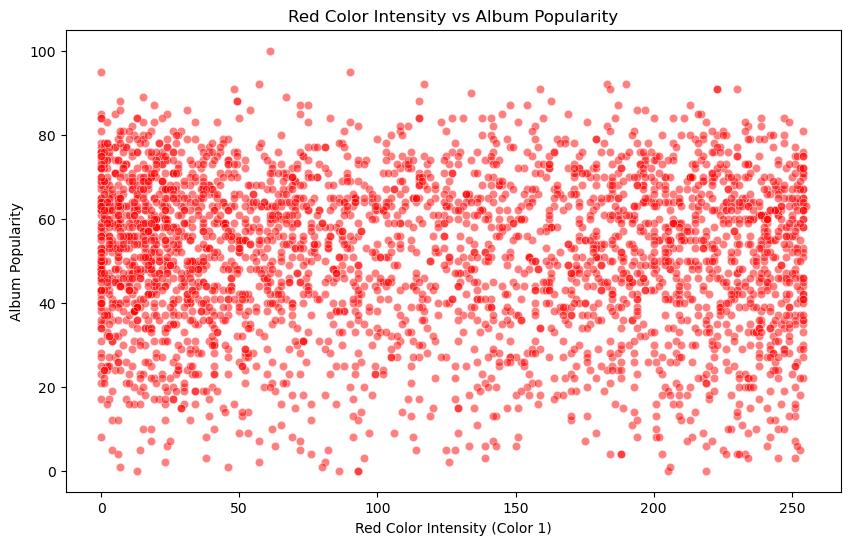

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='color_1_R', y='popularity', color='red', alpha=0.5)
plt.title('Red Color Intensity vs Album Popularity')
plt.xlabel('Red Color Intensity (Color 1)')
plt.ylabel('Album Popularity')
plt.show()


In [58]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier  # or RandomForestRegressor for regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Encoding 'gender_grouped' column
df['gender_encoded'] = label_encoder.fit_transform(df['gender_grouped'])
# Drop non-numeric columns and target column (adjust for your dataset)
X = df.drop(columns=['genre', 'gender_grouped','genre_condensed', 'Unnamed: 0', 'artist_name', 'artist_id', 'album_id', 'album_name', 'release_date', 'image_url'])

# Encode the target variable (e.g., 'genre')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['genre_condensed'])  # This converts the genre into numeric labels

# Handle missing values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier (or RandomForestRegressor)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame with feature names and their corresponding importance scores
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# Sort the features by importance (highest to lowest)
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Print the feature importances
print(feature_importances)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances from Random Forest')
plt.show()


ValueError: could not convert string to float: 'female'